Import's


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb


In [2]:
%matplotlib inline
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (11, 5)

In [3]:
try:
    df = pd.read_csv("merged_data.csv")
    print("Data loaded successfully!")
except FileNotFoundError:
    print("ERROR: merged_data.csv not found. Please make sure the file is in the notebook directory.")

print("Number of records:", df.shape[0])
display(df.head())

print("Column names:", df.columns.tolist())
df.info()

Data loaded successfully!
Number of records: 175320


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,Category
0,1,2013,3,1,0,3.0,6.0,13.0,7.0,300.0,85.0,-2.3,1020.8,-19.7,0.0,E,0.5,Changping,Rural
1,2,2013,3,1,1,3.0,3.0,6.0,6.0,300.0,85.0,-2.5,1021.3,-19.0,0.0,ENE,0.7,Changping,Rural
2,3,2013,3,1,2,3.0,3.0,22.0,13.0,400.0,74.0,-3.0,1021.3,-19.9,0.0,ENE,0.2,Changping,Rural
3,4,2013,3,1,3,3.0,6.0,12.0,8.0,300.0,81.0,-3.6,1021.8,-19.1,0.0,NNE,1.0,Changping,Rural
4,5,2013,3,1,4,3.0,3.0,14.0,8.0,300.0,81.0,-3.5,1022.3,-19.4,0.0,N,2.1,Changping,Rural


Column names: ['No', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station', 'Category']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175320 entries, 0 to 175319
Data columns (total 19 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   No        175320 non-null  int64  
 1   year      175320 non-null  int64  
 2   month     175320 non-null  int64  
 3   day       175320 non-null  int64  
 4   hour      175320 non-null  int64  
 5   PM2.5     171488 non-null  float64
 6   PM10      172552 non-null  float64
 7   SO2       171529 non-null  float64
 8   NO2       169794 non-null  float64
 9   CO        164659 non-null  float64
 10  O3        170176 non-null  float64
 11  TEMP      175123 non-null  float64
 12  PRES      175129 non-null  float64
 13  DEWP      175120 non-null  float64
 14  RAIN      175127 non-null  float64
 15  wd        174398 non-null  object 
 16 

4. Exploratory Data Analysis (EDA)


EDA - Missing Values


Missing values per column:


PM2.5     3832
PM10      2768
SO2       3791
NO2       5526
CO       10661
O3        5144
TEMP       197
PRES       191
DEWP       200
RAIN       193
wd         922
WSPM       158
dtype: int64

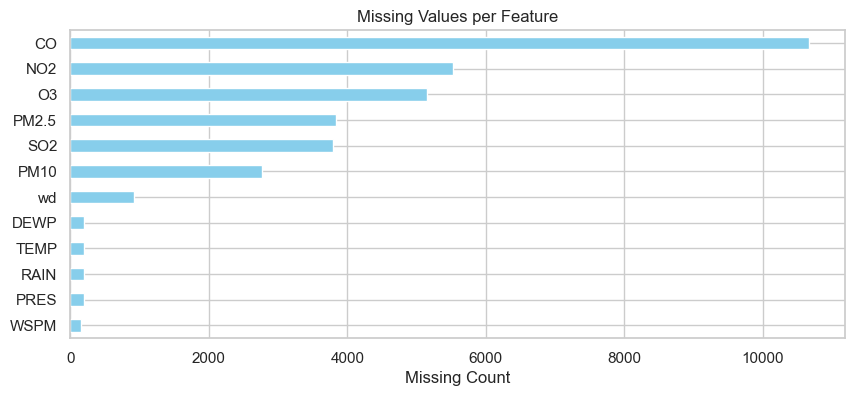

In [4]:
missing_values = df.isnull().sum()
print("Missing values per column:")
display(missing_values[missing_values > 0])

if (missing_values > 0).any():
    plt.figure(figsize=(10,4))
    missing_values[missing_values > 0].sort_values().plot(kind='barh', color='skyblue')
    plt.xlabel('Missing Count')
    plt.title('Missing Values per Feature')
    plt.show()
else:
    print('No missing values.')

Correlation Heatmap


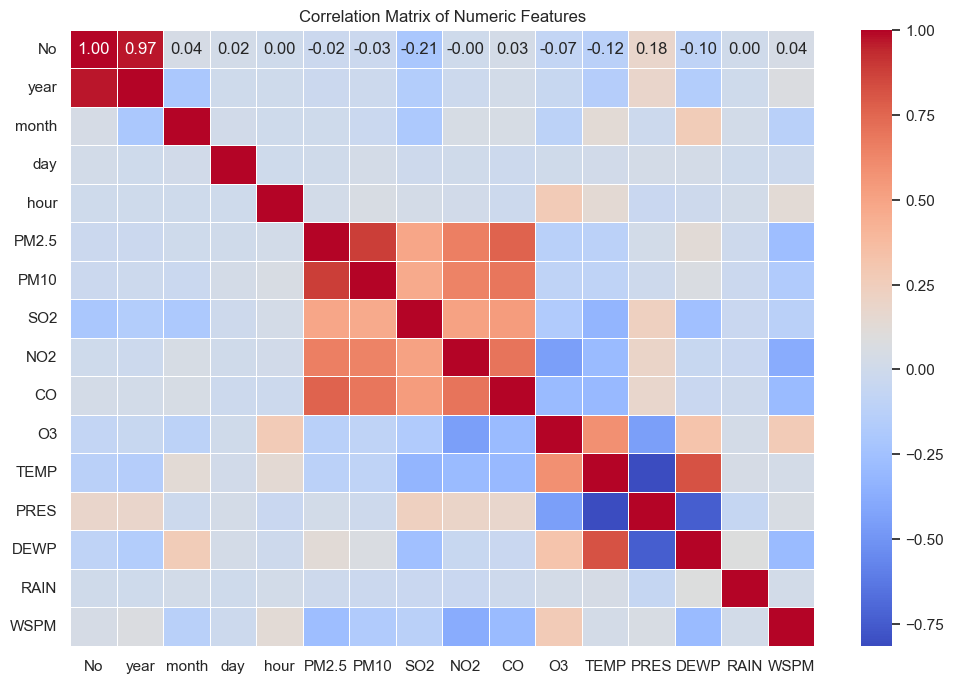

In [5]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

corr_matrix = df[numeric_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numeric Features")
plt.show()

Feature Correlations with PM2.5


Absolute Correlation with PM2.5

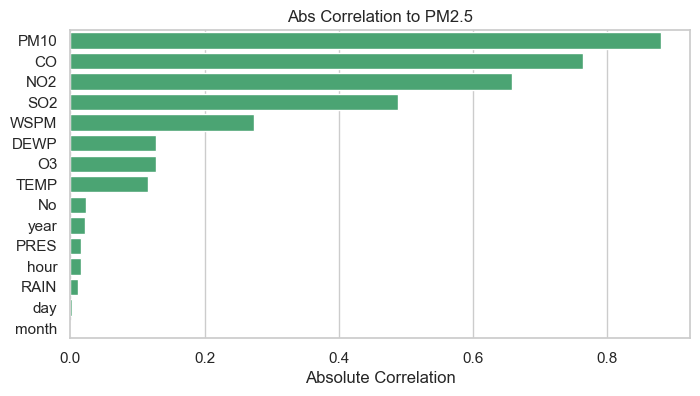

In [6]:
if 'PM2.5' in corr_matrix.columns:
    pm25_corr = corr_matrix['PM2.5'].drop('PM2.5').abs().sort_values(ascending=False)
    plt.figure(figsize=(8,4))
    sns.barplot(x=pm25_corr.values, y=pm25_corr.index, color="mediumseagreen")
    plt.title("Abs Correlation to PM2.5")
    plt.xlabel('Absolute Correlation')
    plt.show()

Time Series - Daily and Monthly PM2.5


Time-series plot

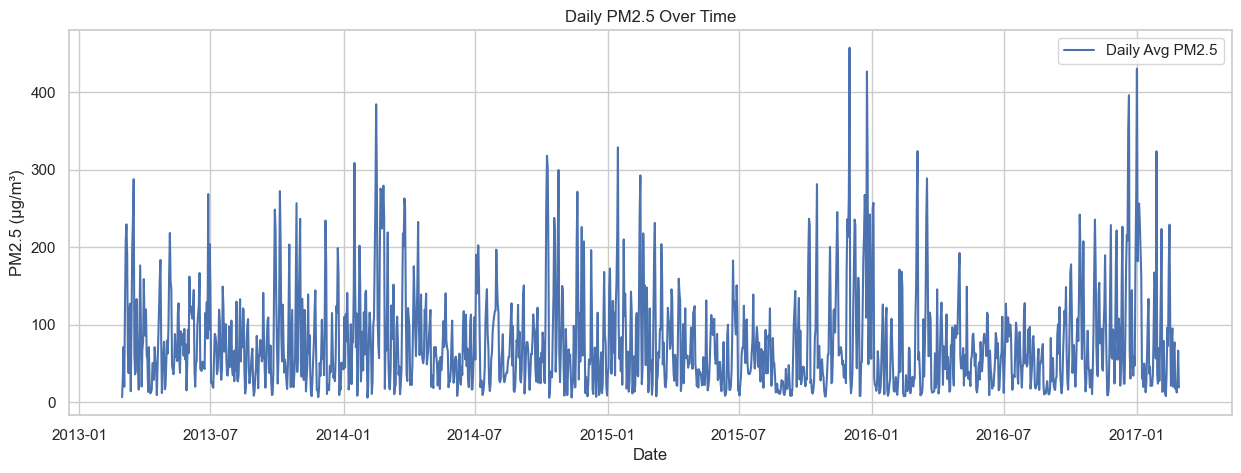

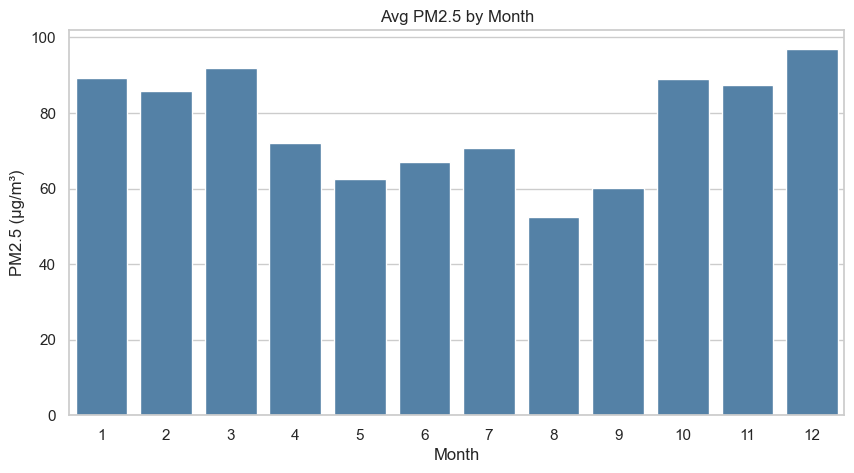

In [7]:
if set(['year','month','day','hour']).issubset(df.columns):
    df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
    df = df.set_index('datetime')
    daily_avg_pm25 = df['PM2.5'].resample('D').mean()
    plt.figure(figsize=(15, 5))
    plt.plot(daily_avg_pm25, label='Daily Avg PM2.5')
    plt.title("Daily PM2.5 Over Time")
    plt.xlabel("Date")
    plt.ylabel("PM2.5 (µg/m³)")
    plt.legend()
    plt.show()

    monthly_avg_pm25 = df.groupby('month')['PM2.5'].mean()
    plt.figure(figsize=(10, 5))
    sns.barplot(x=monthly_avg_pm25.index, y=monthly_avg_pm25.values, color="steelblue")
    plt.title("Avg PM2.5 by Month")
    plt.xlabel("Month")
    plt.ylabel("PM2.5 (µg/m³)")
    plt.show()
else:
    print("No [year, month, day, hour] info in columns!")


PM2.5 Distribution


Histogram of PM2.5

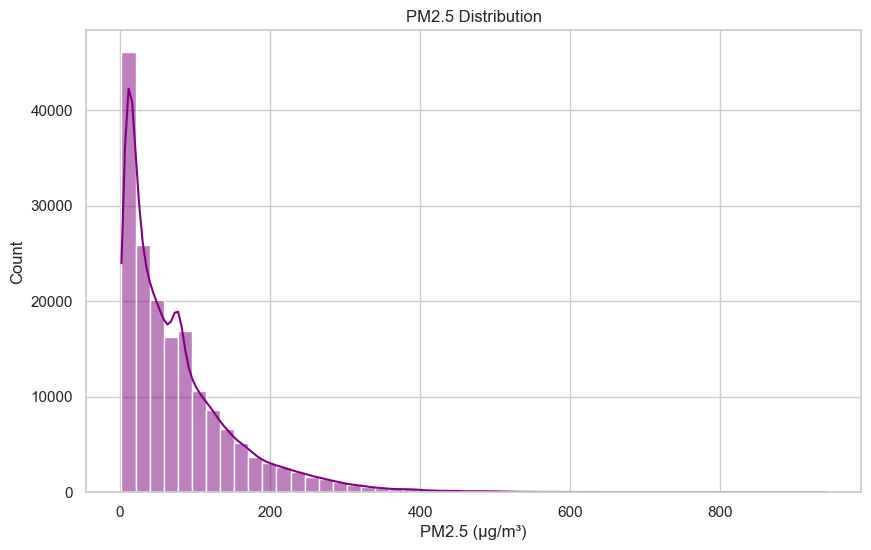

In [8]:
plt.figure(figsize=(10,6))
sns.histplot(df['PM2.5'], bins=50, kde=True, color="purple")
plt.title("PM2.5 Distribution")
plt.xlabel("PM2.5 (µg/m³)")
plt.show()


Violin Plot


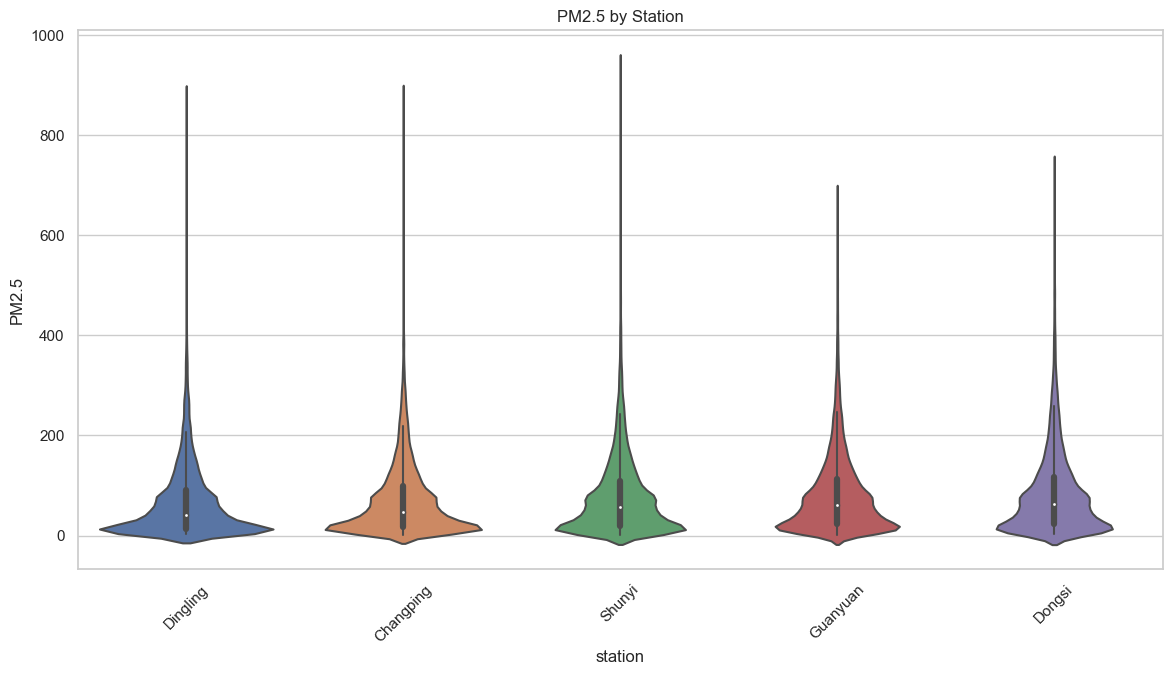

In [9]:
if 'station' in df.columns:
    plt.figure(figsize=(14,7))
    order = df.groupby('station')['PM2.5'].mean().sort_values().index
    sns.violinplot(x='station', y='PM2.5', data=df.reset_index(), order=order)
    plt.xticks(rotation=45)
    plt.title('PM2.5 by Station')
    plt.show()

Scatterplot

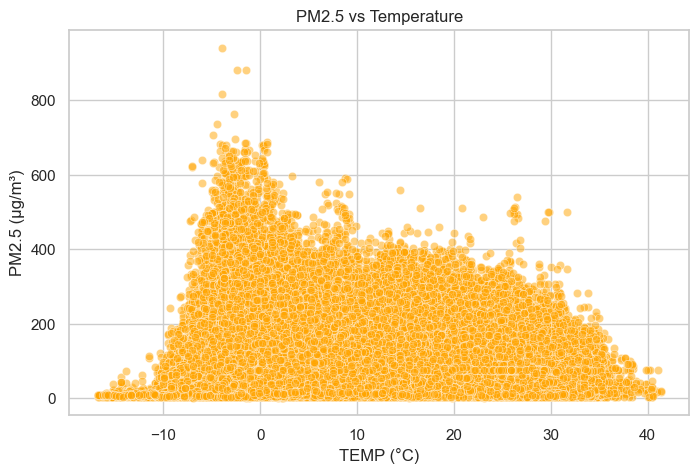

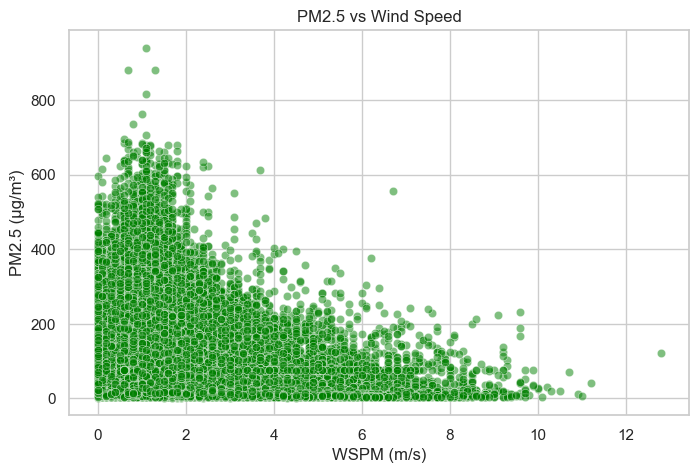

In [10]:
if 'TEMP' in df.columns and 'PM2.5' in df.columns:
    plt.figure(figsize=(8,5))
    sns.scatterplot(x=df['TEMP'], y=df['PM2.5'], alpha=0.5, color="orange")
    plt.title('PM2.5 vs Temperature')
    plt.xlabel("TEMP (°C)"); plt.ylabel("PM2.5 (µg/m³)")
    plt.show()
if 'WSPM' in df.columns and 'PM2.5' in df.columns:
    plt.figure(figsize=(8,5))
    sns.scatterplot(x=df['WSPM'], y=df['PM2.5'], alpha=0.5, color="green")
    plt.title('PM2.5 vs Wind Speed')
    plt.xlabel("WSPM (m/s)"); plt.ylabel("PM2.5 (µg/m³)")
    plt.show()

Pair Plot

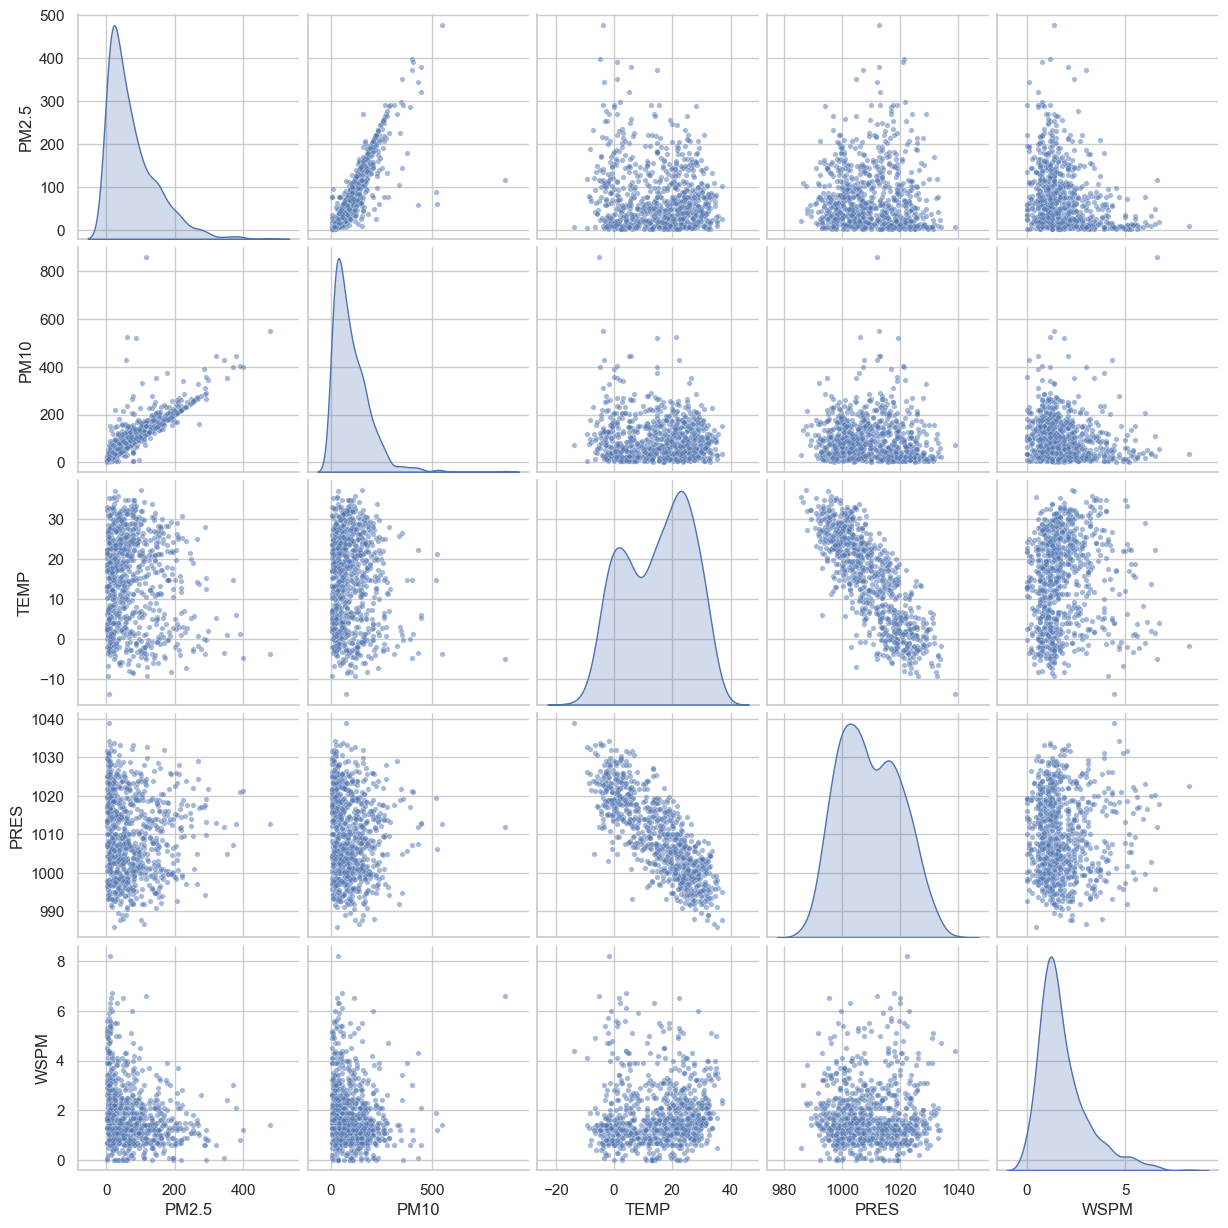

In [11]:
pairplot_cols = ['PM2.5','PM10','TEMP','PRES','WSPM']
subset = df[pairplot_cols].dropna()
if subset.shape[0] > 800:
    subset = subset.sample(800, random_state=1)
sns.pairplot(subset, diag_kind='kde', plot_kws={'alpha':0.5,'s':15})
plt.show()

Modeling

In [12]:
FEATURES = ["PM10", "SO2", "NO2", "CO", "O3", "TEMP", "PRES", "RAIN", "WSPM"]
TARGET = "PM2.5"

X = df[FEATURES].fillna(df[FEATURES].mean())
y = df[TARGET].fillna(df[TARGET].mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print("X_train shape:", X_train.shape)

X_train shape: (140256, 9)


Model Training


In [13]:

models = {
    "Gradient Boosting": GradientBoostingRegressor(),
    "Random Forest": RandomForestRegressor(),
    "XGBoost": xgb.XGBRegressor(),
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge()
}

results = []
trained_models = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({"Model": name, "MSE": mse, "R2": r2, "Accuracy (%)": r2*100})
    trained_models[name] = model

results_df = pd.DataFrame(results).sort_values("Accuracy (%)", ascending=False)
display(results_df)

,Model,MSE,R2,Accuracy (%)
1,Random Forest,447.578918,0.926299,92.629875
2,XGBoost,468.740938,0.922814,92.281407
0,Gradient Boosting,611.304552,0.899339,89.933862
4,Ridge Regression,994.346867,0.836264,83.626438
3,Linear Regression,994.346875,0.836264,83.626438


Model Interpretation & Feature Importance

Best Model: Random Forest
MSE: 447.58, R2: 0.926, Accuracy: 92.63%
Feature importances:
 PM10    0.806112
CO      0.089325
TEMP    0.022429
SO2     0.020085
NO2     0.017885
PRES    0.015704
WSPM    0.013978
O3      0.013595
RAIN    0.000887
dtype: float64


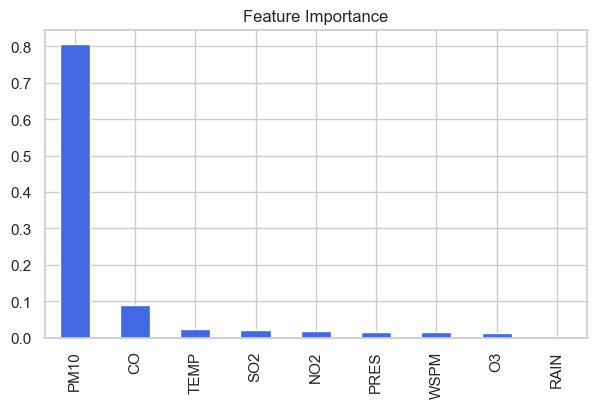

In [14]:
best_model_name = results_df.iloc[0]['Model']
model = trained_models[best_model_name]
print(f"Best Model: {best_model_name}")

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.2f}, R2: {r2:.3f}, Accuracy: {r2*100:.2f}%")

if hasattr(model, 'feature_importances_'):
    fi = pd.Series(model.feature_importances_, index=FEATURES).sort_values(ascending=False)
    print("Feature importances:\n", fi)
    fi.plot(kind='bar', color="royalblue", figsize=(7,4), title="Feature Importance")
    plt.show()
elif hasattr(model, 'coef_'):
    fi = pd.Series(model.coef_, index=FEATURES).sort_values(key=abs, ascending=False)
    print("Model coefficients:\n", fi)
    fi.plot(kind='bar', color="tomato", figsize=(7,4), title="Model Coefficients")
    plt.show()

Actual vs Predicted Plots

First 10 predictions vs actuals:


,Actual PM2.5,Predicted PM2.5
0,109.0,124.960000
1,23.0,28.650000
2,106.0,78.594402
3,51.0,97.130000
4,5.0,8.310000
5,43.0,48.050000
6,41.0,32.210000
7,269.0,257.160000
8,18.0,32.850000
9,118.0,77.870000


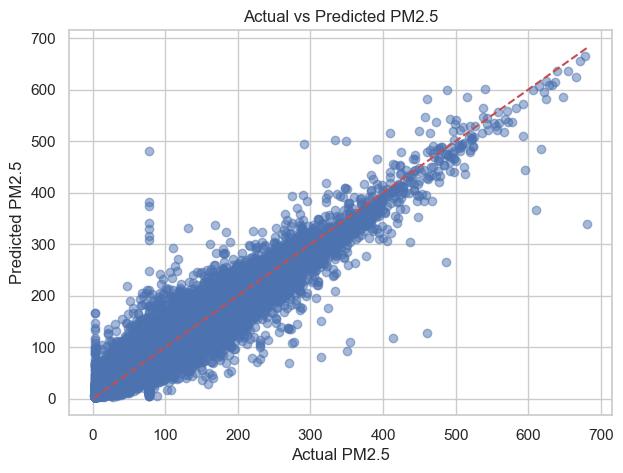

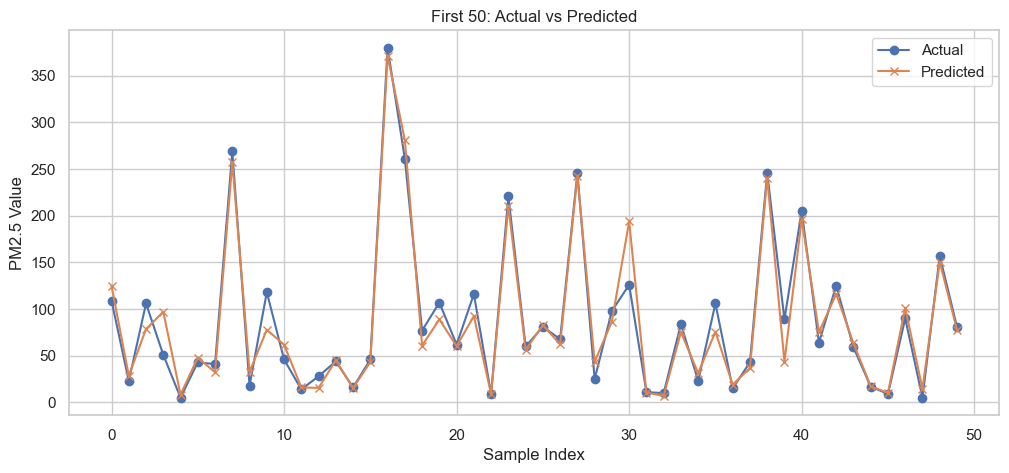

In [15]:
print("First 10 predictions vs actuals:")
display(pd.DataFrame({"Actual PM2.5": y_test.values[:10], "Predicted PM2.5": y_pred[:10]}).reset_index(drop=True))

# Scatter plot
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual PM2.5")
plt.ylabel("Predicted PM2.5")
plt.title("Actual vs Predicted PM2.5")
plt.show()

# Line plot of first 50 points
plt.figure(figsize=(12,5))
plt.plot(y_test.values[:50], label="Actual", marker='o')
plt.plot(y_pred[:50], label="Predicted", marker='x')
plt.xlabel("Sample Index")
plt.ylabel("PM2.5 Value")
plt.title("First 50: Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.show()

Learning Curve

In [17]:
# train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5)
# plt.figure(figsize=(8,5))
# plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score', color='blue')
# plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation Score', color='red')
# plt.xlabel('Training Size')
# plt.ylabel('Score')
# plt.title('Learning Curve')
# plt.legend()
# plt.show()

User Input Simulation

In [18]:

print("Try PM2.5 prediction for custom feature values (change input_features dict!)")
input_features = {
    'PM10': X[FEATURES[0]].mean(),
    'SO2':  X[FEATURES[1]].mean(),
    'NO2':  X[FEATURES[2]].mean(),
    'CO':   X[FEATURES[3]].mean(),
    'O3':   X[FEATURES[4]].mean(),
    'TEMP': X[FEATURES[5]].mean(),
    'PRES': X[FEATURES[6]].mean(),
    'RAIN': X[FEATURES[7]].mean(),
    'WSPM': X[FEATURES[8]].mean(),
}
print("Input Features:", input_features)

input_array = np.array([list(input_features.values())])
pred = model.predict(input_array)[0]
print(f"\nPredicted PM2.5 concentration: {pred:.2f} µg/m³")

# Categorize air quality
if pred <= 50:
    quality = "Good"
elif pred <= 100:
    quality = "Moderate"
elif pred <= 150:
    quality = "Unhealthy for sensitive groups"
elif pred <= 200:
    quality = "Unhealthy"
elif pred <= 300:
    quality = "Very Unhealthy"
else:
    quality = "Hazardous"
print("Air Quality:", quality)

Try PM2.5 prediction for custom feature values (change input_features dict!)
Input Features: {'PM10': 99.3159725763828, 'SO2': 15.290692601251102, 'NO2': 45.47677087294016, 'CO': 1168.0591707711087, 'O3': 58.93519030768147, 'TEMP': 13.603264626057111, 'PRES': 1010.595901266666, 'RAIN': 0.06265453071199756, 'WSPM': 1.816886653497905}

Predicted PM2.5 concentration: 77.12 µg/m³
Air Quality: Moderate


c:\Users\dheen\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [20]:
import os
import joblib

# Directory to save models
output_dir = "saved_models/"
os.makedirs(output_dir, exist_ok=True)

for name, model in trained_models.items():
    file_path = os.path.join(output_dir, f"{name}.h5")
    joblib.dump(model, file_path)

print(f"Models saved successfully in {output_dir}")


Models saved successfully in saved_models/
